In [28]:
import numpy as np
from numpy.polynomial.hermite_e import hermefit, hermeval
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [18]:
### 1.1
def coeffsForCondiExp(X,Y,hermiteOrder):
    return hermefit(X, Y, hermiteOrder)

#beta = coeffsForCondiExp(X,Y,hermiteOrder)

def approxCondExp(X,beta):
    return hermeval(X, beta)

The model is very similar to last question, difference incurred by the stochastic term, and for convenience, we set all the parameters to be a constant such that our model can be well defiened.
$$d X_{t}=\left[L(t) X_{t}+M(t) \alpha_{t}\right] d t+\sigma(t) d W_{t} \text { for } t \in[0, T], \quad X_{0}=x$$

In [19]:
# set the parameters
sigma = 0.2
N_mc = 20**2; 
N_basis_f = 3

x0 = 1;L = 1; M =1
R = -3;F = 1;C = -10;D = -5
T = 1 ; N = 100; dt = float(T)/N; t=np.linspace(0,T,N)

epsilon = 10**(-5)# Stopping criteria
delta = 10**(-4) # Learning rate

In [20]:
##initial value for alpha
alpha = np.ones((N_mc,N))
alpha = 0.5 * alpha

In [21]:
#  initialize the brownian motion
dW_df = np.zeros((N_mc,N-1))
WT = np.zeros(N_mc)

#simuliate the brownian motion & St for N_mc paths
for i in range(N_mc):
    dW=np.sqrt(dt)*np.random.randn(1,N-1)
    dW_df[i] = dW
    
    W=np.cumsum(dW)
    WT[i] = W[-1]

Solve $\hat X_{t}$ and $\hat Y_t$ numeraically

In [22]:
X = np.zeros((N_mc,N))
X[:,0] = x0*np.ones(N_mc)
def update_x_stoch(X,alpha):
    for j in range(N_mc):
        for i in range(1,N):  
            X[j,i] = X[j,i-1] + (L * X[j,i-1] + M * alpha[j,i-1]) * dt + sigma*dW_df[j,i-1]
    return X

Follow the method in Question 2 to solve the BSDE numerically.
$$
d \hat{Y}_{t}=-\left[L(t) \hat{Y}_{t}+2 C(t) \hat{X}_{t}+2 F(t) \hat{\alpha}\right]d t +\hat Z_t d W_t\text { for } t \in[0, T], \quad \hat{Y}_{T}=2 R \hat{X}_{T}
$$

In [23]:
# initialize the simulated Yt process
def update_y_stoch(Y_df,X,alpha):
    Y_df[:,-1] = np.ones(N_mc)*2*R*X[:,-1]
    Z_df = np.zeros((N_mc,N-1))

    for i in range(N-2,-1,-1):
        #Simulated Yt process
        # according to the iterative formula, estimate the condition value for Z and simulated Y for each time step
        beta_Z = coeffsForCondiExp(X[:,i],Y_df[:,i+1]*dW_df[:,i],N_basis_f)
        Z_df[:,i] = approxCondExp(X[:,i],beta_Z)/dt

        beta_Y = coeffsForCondiExp(X[:,i],Y_df[:,i+1] + (L*Y_df[:,i+1] + 2*C*X[:,i+1] + 2*F*alpha[:,i+1]) * dt,N_basis_f)
        Y_df[:,i] = approxCondExp(X[:,i],beta_Y)
    return Y_df

Find the optimal $\alpha$ that maximized $J$
#### Warning!
The cell below may take 6-10 minutes to run

In [24]:
flag = True
count = 0
while flag == True:
    count += 1
    X = update_x_stoch(X,alpha)
    Y_df = np.zeros((N_mc,N))
    Y = update_y_stoch(Y_df,X,alpha)

    for i in range(N):## by setting, alpha does not vary among different paths, since it does not control diffusion term.
        alpha[:,i] = alpha[:,i] + delta*(2*D*alpha[:,i]+2*F*X[:,i]+M*Y[:,i])
    
    P_J = 0
    for path in range(N_mc):
        P_J += np.sum((C*X[path]**2+ D*alpha[path]**2 + 2*F*X[path]*alpha[path])*dt) + R*X[path][-1]**2
    P_J = P_J / N_mc

    if count == 1:
        J = P_J
        #print(X[0])
        continue

    if J + epsilon > P_J:
        flag = False
        print("Solution convergent")
        print(f'The value of J is {P_J}')
    elif P_J < J:
        flag = False
        print("Failed")
        print(f'The value of J is {P_J}')
    if count > 10000:
        print('Too many iterations')
        break

    J = P_J


print(f'The total iteration is {count}')

Solution convergent
The value of J is -14.706775135525252
The total iteration is 1502


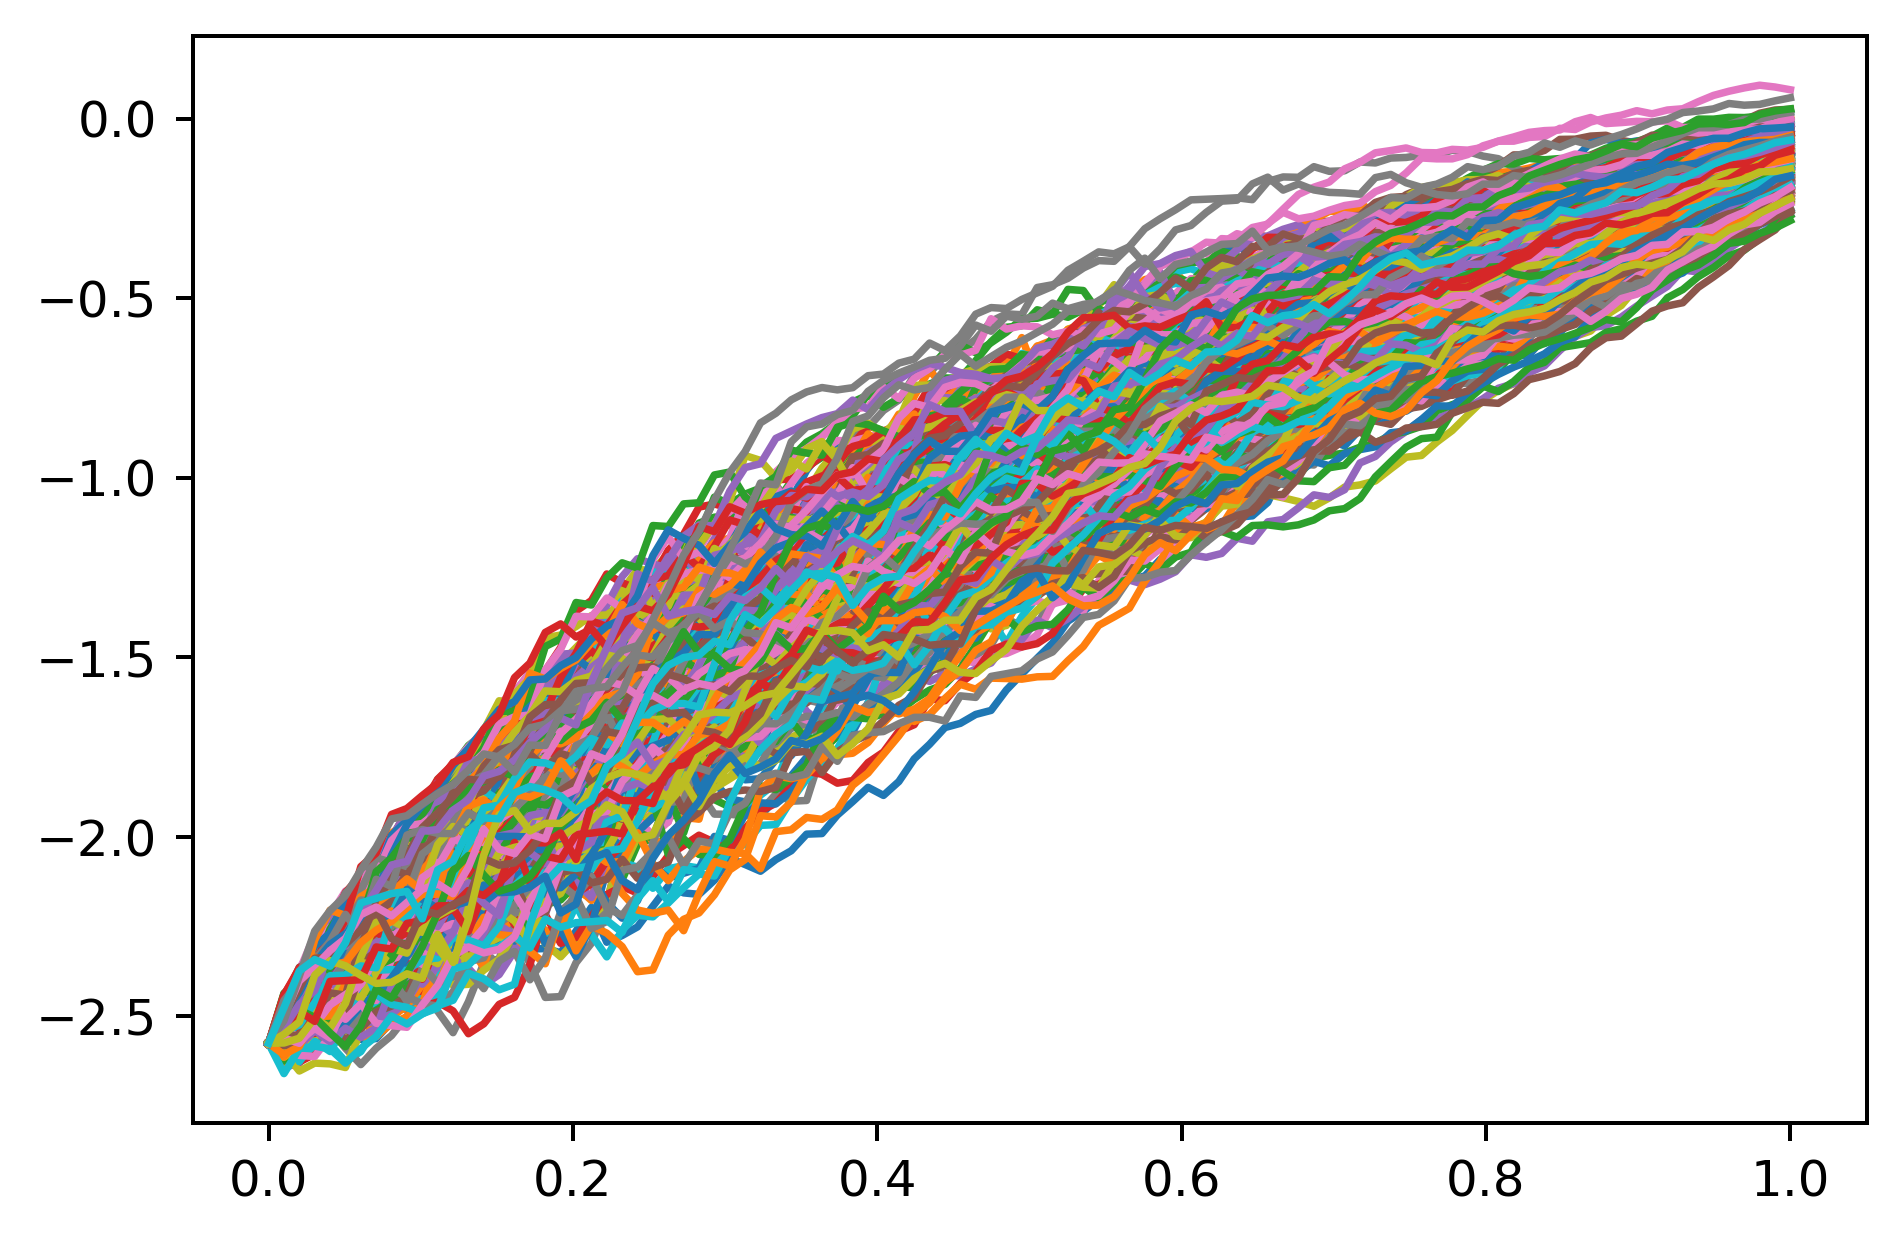

In [39]:
plt.figure(dpi=360)
for i in range(N_mc):
    plt.plot(t,alpha[i])

### Calculate the exact solution 

In [26]:
SS = np.zeros(N)
SS[-1] = R
for i in range(N-2,-1,-1):
    SS[i] = SS[i+1] - ((SS[i+1]*M+F)/D*(M*SS[i+1]+F)-2*L*SS[i+1]-C)*dt
S =np.ones((N_mc,N))
for i in range(N_mc):
    S[i,:] = SS
    
X = np.zeros((N_mc,N))
X[:,0] = x0*np.ones(N_mc)
for i in range(N-1):
    X[:,i+1] = (-(2*L*S[:,i]*X[:,i]+2*C*X[:,i]-2*F/D*M*S[:,i]*X[:,i]-2/D*F**2*X[:,i])*dt+
              2*S[:,i]*sigma*dW_df[:,i] +
              2*S[:,i]*X[:,i])/(2*S[:,i+1])
alpha_true = -(M*S+F)/D*X

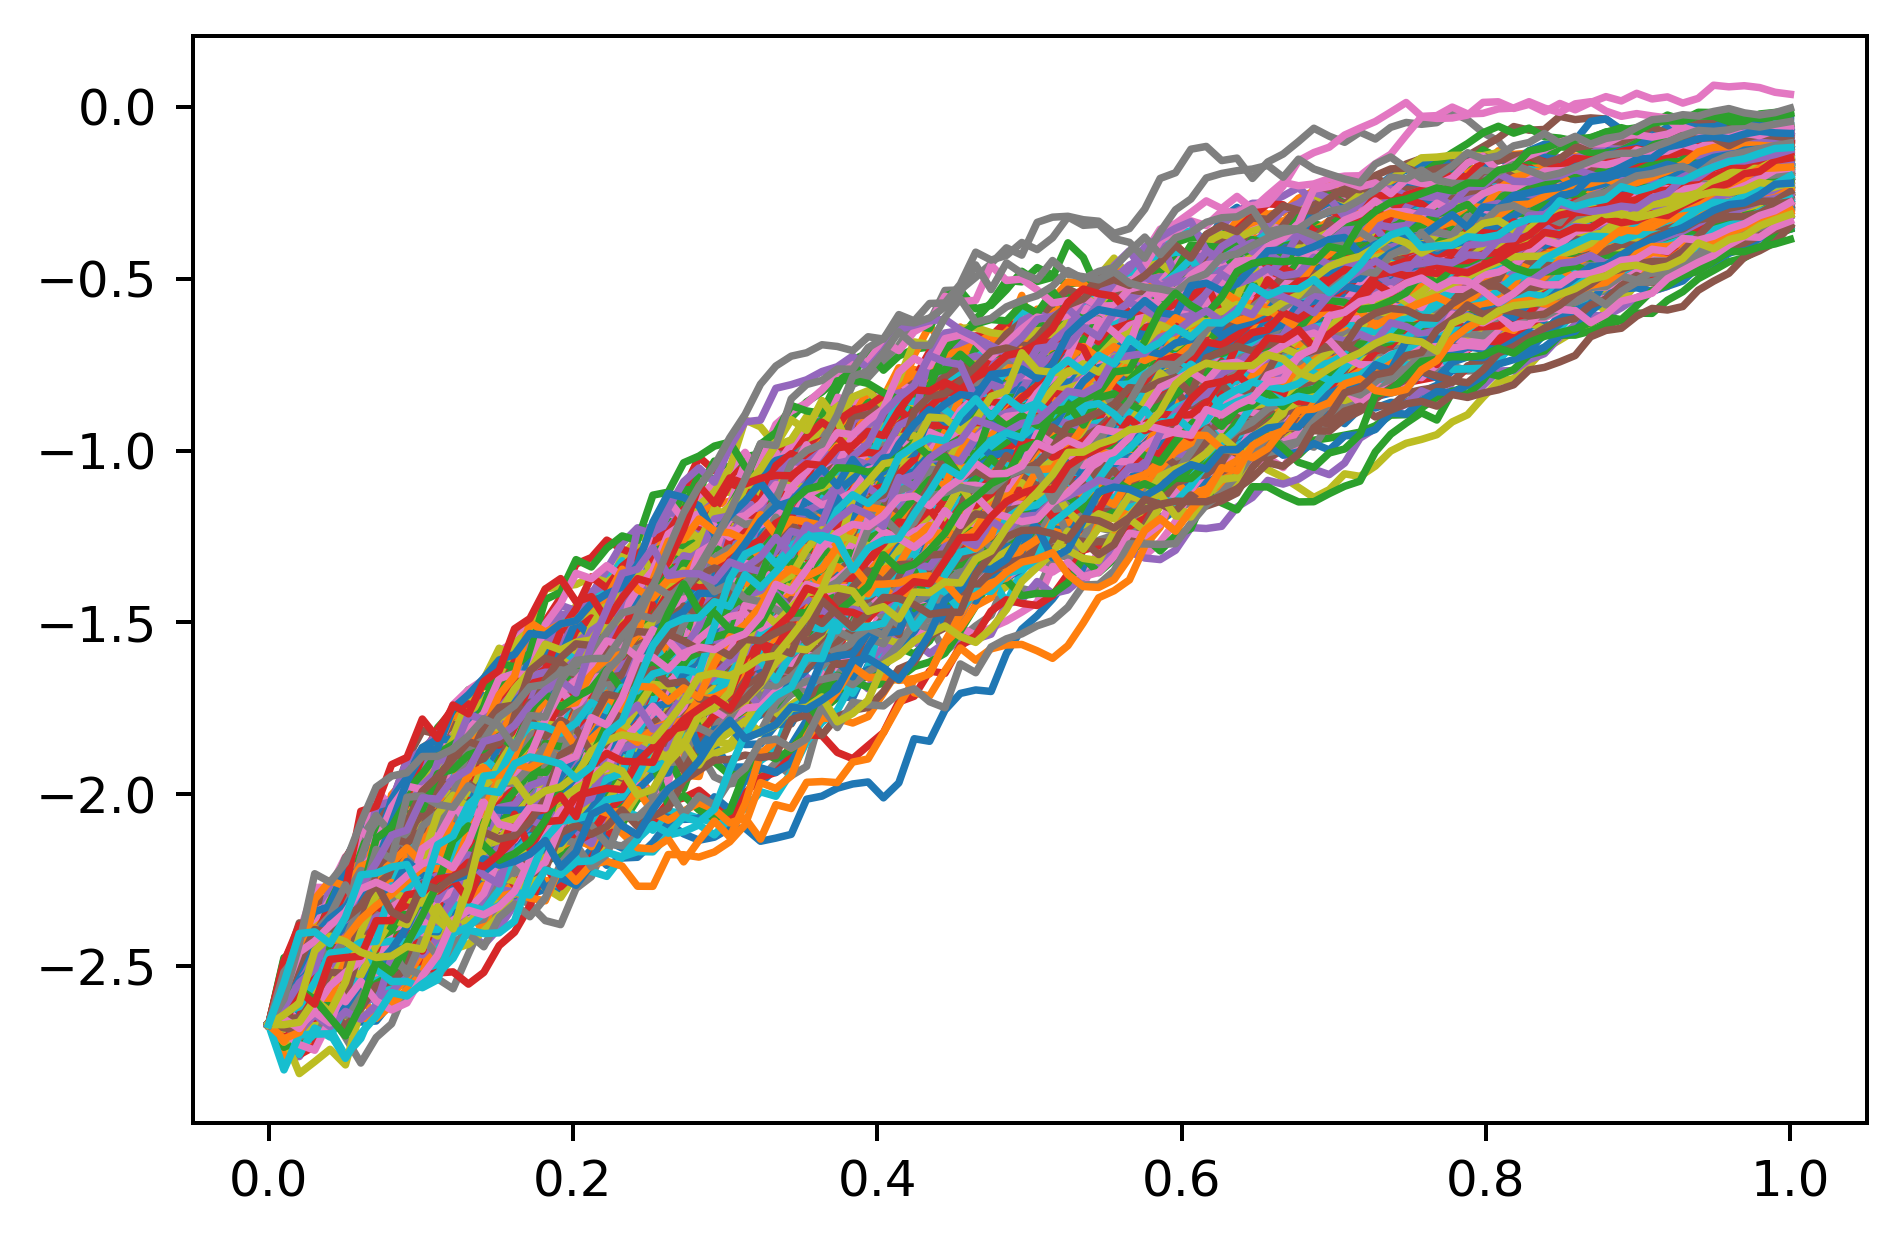

In [27]:
plt.figure(dpi=360)
for i in range(N_mc):
    plt.plot(t,alpha_true[i])

Compare the exact solution with the numerical solution by rondomly choose one sample from all solution. You can run the cell below multiple times, each time you will get different sample solution.

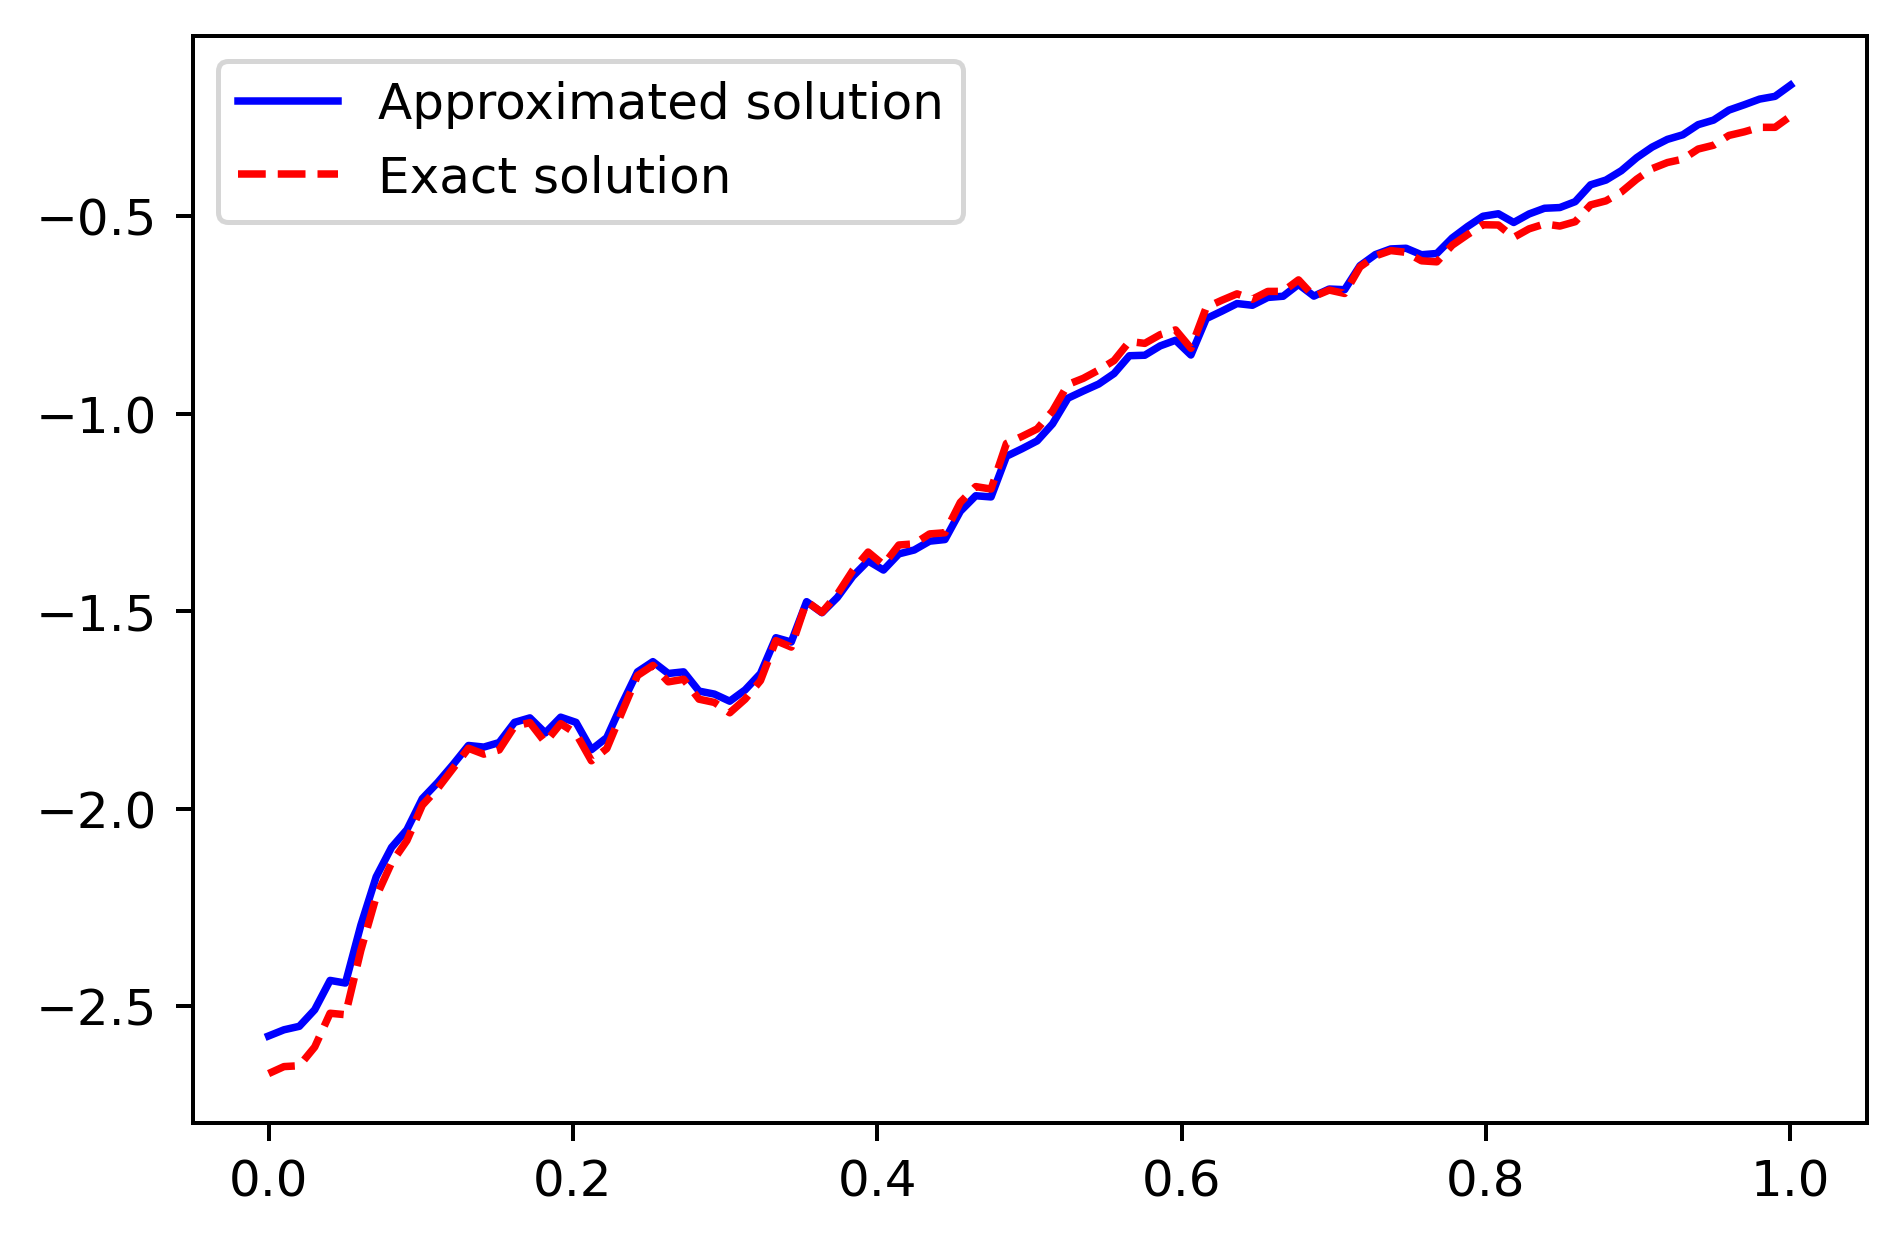

In [40]:
sample_path_index = rng.integers(N_mc)
plt.figure(dpi=360)
l1, = plt.plot(t,alpha[sample_path_index],'b-')
l2, = plt.plot(t,alpha_true[sample_path_index],'r--')
plt.legend(handles=[l1,l2,],labels=['Approximated solution','Exact solution'],loc='best')